In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Jupiter magic command, read above
%matplotlib inline

In [2]:
# Let's create a random walk. First value is zero (100), next value adds a random increment/decrement

np.random.seed(26)

steps = np.random.standard_normal(500)
steps[0]=100

random_walk = np.cumsum(steps)

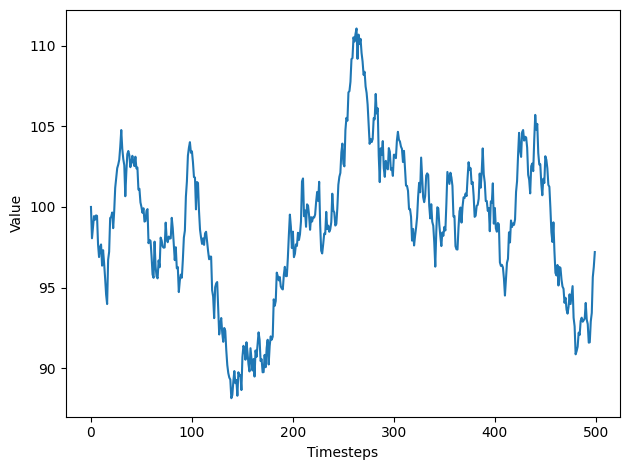

In [3]:
# Plot the random_walk we just created

fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig('figures/CH03_exercise_3.5.1_figure_1.png', dpi=300)

In [4]:
# Test for Stationarity
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# ADF Statistic = -2.40 (is not a large negative number) and p-value = 0.14 (greater than 0.05), thus we cannot reject the null hypothesis (non-stationarity), 
# thus the random walk series is non-stationary

ADF Statistic: -2.398559046633477
p-value: 0.14214352023042082


In [5]:
# Apply a first-order differencing

diff_random_walk = np.diff(random_walk, n=1)

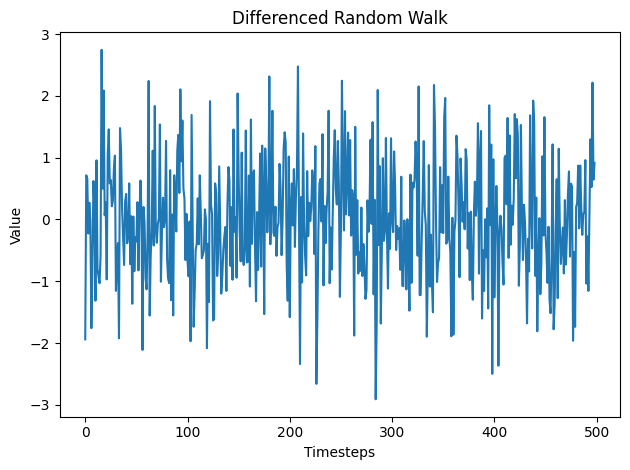

In [6]:
# Plot the first-order difference of the random_walk we just created

plt.plot(diff_random_walk)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()

plt.savefig('figures/CH03_exercise_3.5.1_figure_2.png', dpi=300)

In [7]:
# Test for Stationarity
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# ADF Statistic = -22.66 (is a large negative number) and p-value = 0.0 (greater than 0.05), thus we can reject the null hypothesis (non-stationarity), 
# thus the first-order difference of the random walk series is stationary

ADF Statistic: -22.658454748226866
p-value: 0.0


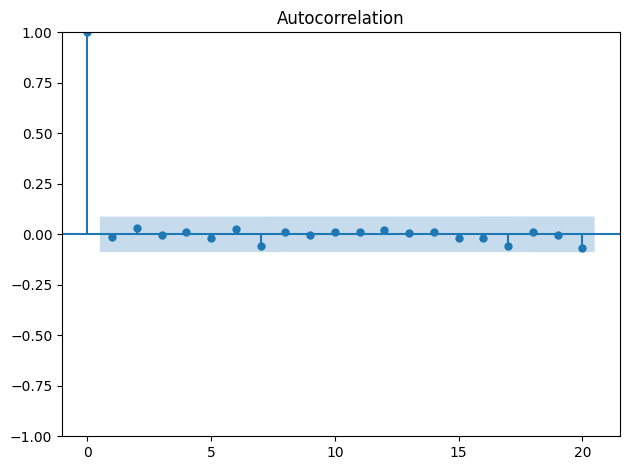

In [8]:
# Check the Autocorrelation Function plot

plot_acf(diff_random_walk, lags=20);

plt.tight_layout()

plt.savefig('figures/CH03_exercise_3.5.1_figure_3.png', dpi=300)

No significant coefficients after lag 0. 

Our random_walk series: non-stationary

The first-order differencing of our random_walk series: stationary and uncorrelated. 

Thus, our random_walk series is a random walk, as per definition in pg 35.

In [9]:
# Forecast test

df = pd.DataFrame({'value': random_walk})

train = df[:400]
test = df[400:]

In [10]:
# Predict the historical mean

mean = np.mean(train.value)

test.loc[:, 'pred_mean'] = mean

test.head()

,value,pred_mean
400,99.938834,99.027298
401,98.677821,99.027298
402,98.464734,99.027298
403,99.005890,99.027298
404,98.931065,99.027298


In [11]:
# Predict the last value

last_value = train.iloc[-1].value

test.loc[:, 'pred_last'] = last_value

test.head()

,value,pred_mean,pred_last
400,99.938834,99.027298,98.965113
401,98.677821,99.027298,98.965113
402,98.464734,99.027298,98.965113
403,99.005890,99.027298,98.965113
404,98.931065,99.027298,98.965113


In [12]:
# Predict with the drift method
# Drift method: same historical average rate of change, same historical slope

deltaX = 400 - 1
deltaY = last_value - 100

drift = deltaY / deltaX

x_vals = np.arange(401, 501, 1)

pred_drift = 100 + drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
400,99.938834,99.027298,98.965113,98.959926
401,98.677821,99.027298,98.965113,98.957332
402,98.464734,99.027298,98.965113,98.954738
403,99.005890,99.027298,98.965113,98.952144
404,98.931065,99.027298,98.965113,98.949551


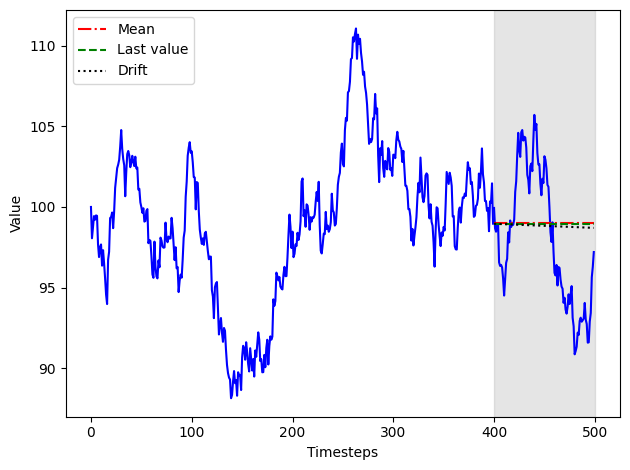

In [13]:
# Plot forecasts

fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(400, 500, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig('figures/CH03_exercise_3.5.1_figure_4.png', dpi=300)

In [14]:
# MSE of the prediction of the test set

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

18.350837636702025 18.224977641051222 17.620175154996353


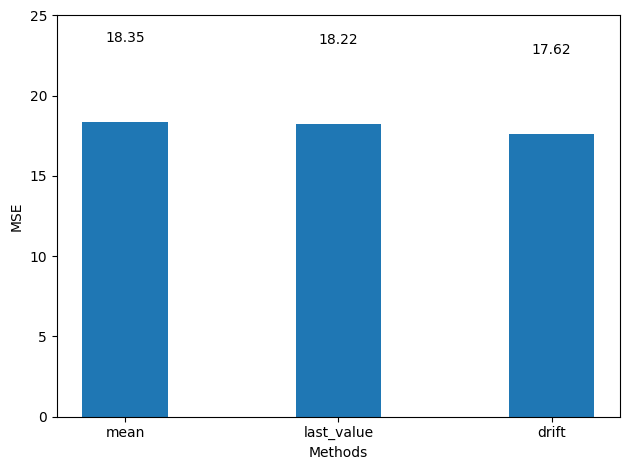

In [15]:
# Plot the MSE of the three (3) methods

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 25)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH03_exercise_3.5.1_figure_5.png', dpi=300)

In [16]:
# Forecasting the next timestep
# Specifically, we will predict the last known value

df_shift = df.shift(periods=1)

df_shift.head()


,value
0,NaN
1,100.000000
2,98.058764
3,98.772549
4,99.434697


In [17]:
# MSE of the prediction of the test set

mse_one_step = mean_squared_error(test['value'], df_shift[400:])

mse_one_step

0.9340281959983181

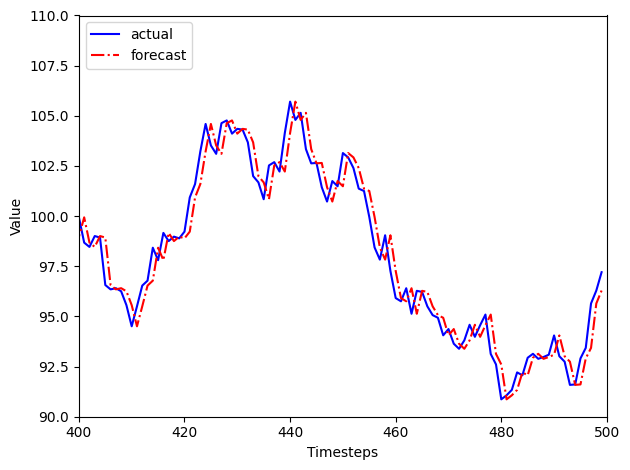

In [18]:
# Actual values and predicted drifted values, last 100 steps

fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlim(400, 500)
ax.set_ylim(90, 110)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

plt.savefig('figures/CH03_exercise_3.5.1_figure_6.png', dpi=300)